<div class="alert alert-block alert-info">
<b>IMPORTS</b>
</div>

In [1]:
#Code to connect your google drive with google colaboratory
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


<div class="alert alert-block alert-info">
<b>Code Citation</b>
</div>

In [ ]:
# Only the Bag of visual words code has been taken and modifed with.
# https://medium.com/@aybukeyalcinerr/bag-of-visual-words-bovw-db9500331b2f

In [5]:
# Packages
import numpy as np
import cv2 as cv
import os
import glob
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import confusion_matrix
from prettytable import PrettyTable
import time
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from fastai.vision import *
%matplotlib inline
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from sklearn.metrics import precision_score, recall_score, f1_score
!pip install --upgrade fastai

<div class="alert alert-block alert-info">
<b>Neural Networks</b>
</div>

In [6]:
# Set the random seed to improve repeatability
set_seed(42)

<div class="alert alert-block alert-info">
<b>Data Loader</b>
</div>

In [7]:
# PATH
norm_path = '/content/drive/MyDrive/Assignment/Images'
# FOLDER PATHS
train_fold = os.path.join(norm_path, "Train")
test_fold = os.path.join(norm_path, "Test")

# RETRIEVEING IMAGES
fnames = get_image_files(train_fold)
# TRAINING DATALOADER
dls = ImageDataLoaders.from_name_re(
    train_fold, # The directory that contains my files
    fnames, # A list of filenames obtained from get_image_files()
    pat=r'digit_(\d+)_row\d+_id_\d+.jpg$',  # Update this based on my filenames, A regex pattern to extract labels from filenames
    item_tfms=Resize(224), #Resize images to 224x224.
    bs=64,# Batch size
    batch_tfms=[Normalize.from_stats(*imagenet_stats)] #Normalize the data using pre-computed ImageNet statistics
)
# TESTING DATALOADER
test_dls = ImageDataLoaders.from_name_re(
    test_fold,
    get_image_files(test_fold),
    pat=r'digit_(\d+)_id_\d+.jpg$',  # Regex pattern to extract labels
    item_tfms=Resize(224),
    bs=64,
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)
# RETRIEVE ALEXNET
learn = cnn_learner(dls, alexnet, metrics=error_rate, n_out=10)


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5

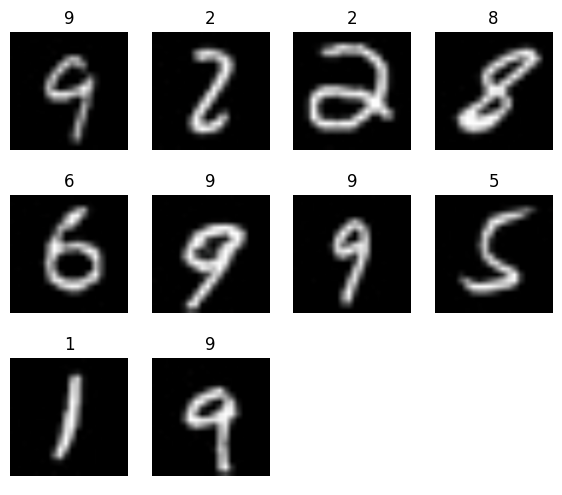

In [ ]:
# SHOW RANDOM TRAIN IMAGES
dls.show_batch(max_n=10, figsize=(7,6))

<div class="alert alert-block alert-info">
<b>Alex-Net Training</b>
</div>

In [ ]:
# TRAIN ALEXNET
learn.fit_one_cycle(4)
# SAVE THE MODEL
learn.save('stage-1')

epoch,train_loss,valid_loss,error_rate,time
0,1.833637,0.365744,0.118750,00:23
1,0.847370,0.201353,0.060000,00:20
2,0.496316,0.176595,0.050000,00:17
3,0.354670,0.158350,0.043750,00:22


Path('/content/drive/MyDrive/Assignment/Images/Train/models/stage-1.pth')

<div class="alert alert-block alert-info">
<b>Alex-Net Loss Metrics</b>
</div>

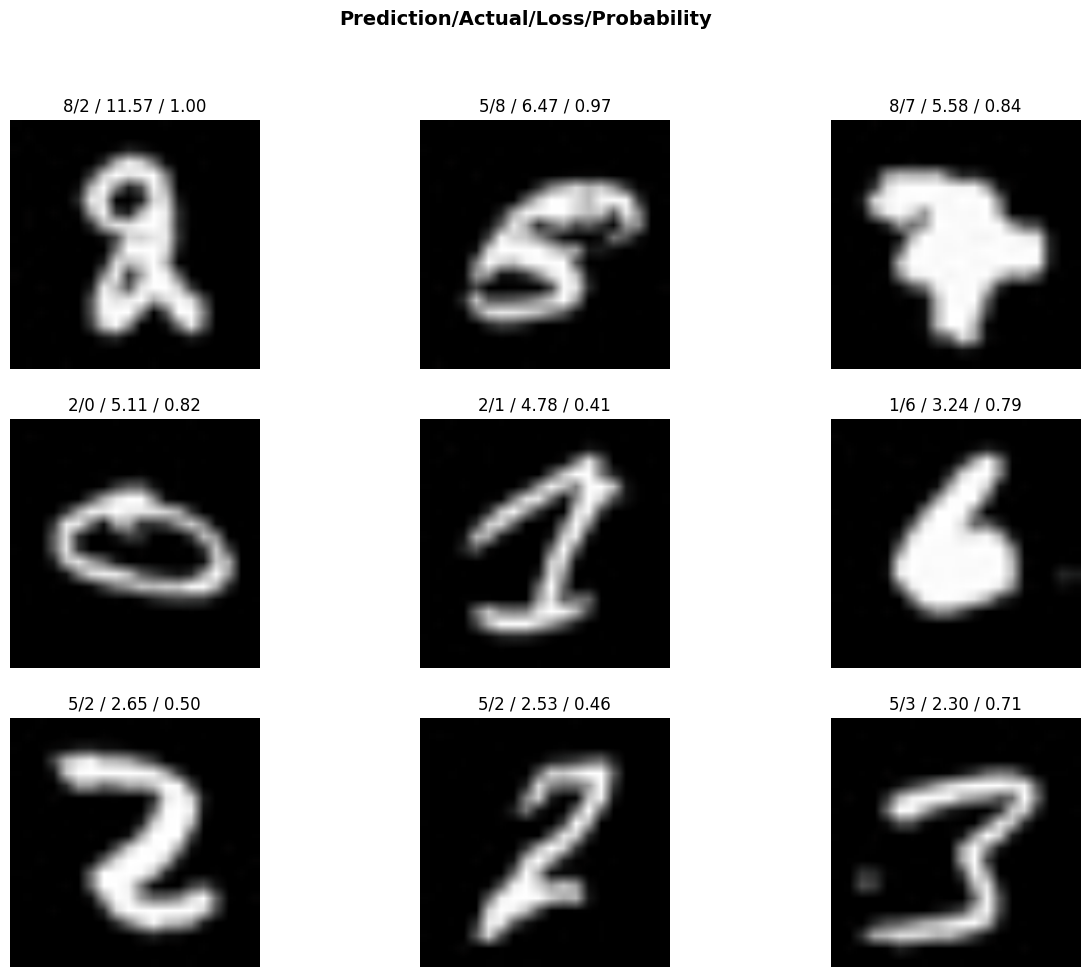

In [ ]:
# Precition/Actual/Loss/Probability
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

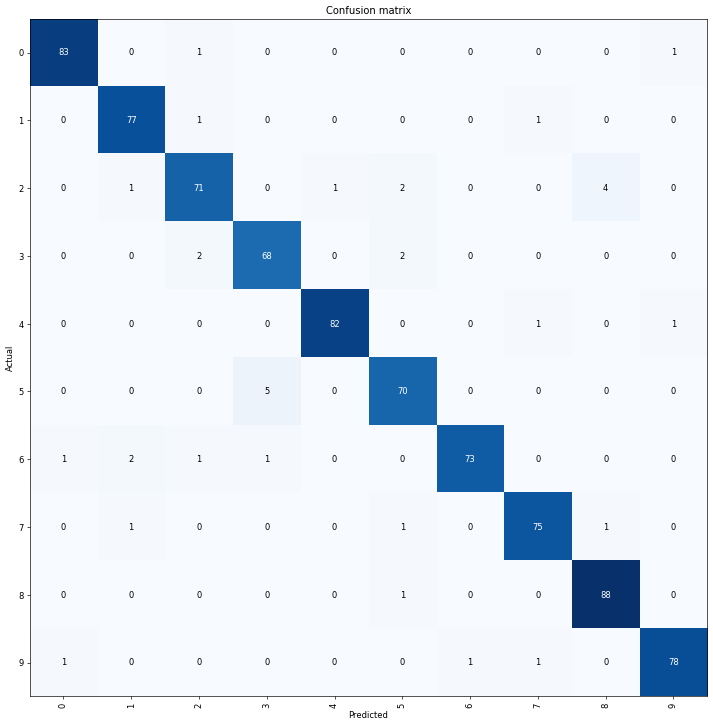

In [ ]:
# CONFUSION MATRIX FOR VALIDATION DATA
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
# NUMBER, CONFUSED, TIMES
interp.most_confused(min_val=2)

[('5', '3', 5),
 ('2', '8', 4),
 ('2', '5', 2),
 ('3', '2', 2),
 ('3', '5', 2),
 ('6', '1', 2)]

<div class="alert alert-block alert-info">
<b>Alex-Net Regularisation via Data Augmentation</b>
</div>

In [ ]:
# Regularisation -> Data Augmentation
# UNEXPECTEDLY GETS WORSE
dls = ImageDataLoaders.from_name_re(
    train_fold,
    fnames,
    pat=r'digit_(\d+)_row\d+_id_\d+.jpg$',
    item_tfms=Resize(460), # resize each image to be 460x460
    bs=64,
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]  # Randomly crop and resize to get a 224x224 region for each image, and normalize the RGB channels
)
learn = cnn_learner(dls, alexnet, metrics=error_rate)
learn.fit_one_cycle(4)
learn.save('stage-1')

epoch,train_loss,valid_loss,error_rate,time
0,2.175023,0.574271,0.171250,00:27
1,1.136379,0.352516,0.103750,00:34
2,0.754286,0.302408,0.085000,00:36
3,0.640896,0.294928,0.091250,00:25


Path('/content/drive/MyDrive/Assignment/Images/Train/models/stage-1.pth')

<div class="alert alert-block alert-info">
<b>AlexNet Accuracy</b>
</div>

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
# CONFUSION MATRIX
confusion_matrix_3 = interp.confusion_matrix()
class_accuracy = confusion_matrix_3.diagonal()/confusion_matrix_3.sum(axis=1)
# LABELS
class_labels = dls.vocab  # Get class labels
# CLASS AND ACCURACY
df = pd.DataFrame({'Class': class_labels, 'Accuracy': class_accuracy})
print(df)

# PREDICTIONS
preds, targs = learn.get_preds()
preds = preds.argmax(dim=1)

from sklearn.metrics import precision_score, recall_score, f1_score
# PRECISION, RECALL AND F1 SCORE
print("Precision: ", precision_score(targs, preds, average='macro'))
print("Recall: ", recall_score(targs, preds, average='macro'))
print("F1 Score: ", f1_score(targs, preds, average='macro'))

  Class  Accuracy
0     0  0.975000
1     1  0.975610
2     2  0.906977
3     3  0.973684
4     4  0.986842
5     5  0.932584
6     6  0.987805
7     7  0.971831
8     8  0.951220
9     9  0.973684


Precision:  0.9630988788285931
Recall:  0.9635236672421712
F1 Score:  0.9631318846732013


<div class="alert alert-block alert-info">
<b>AlexNet Testing Data Accuracy</b>
</div>

Precision:  0.9752795854936123
Recall:  0.9747748024752244
F1 Score:  0.9747276948274329


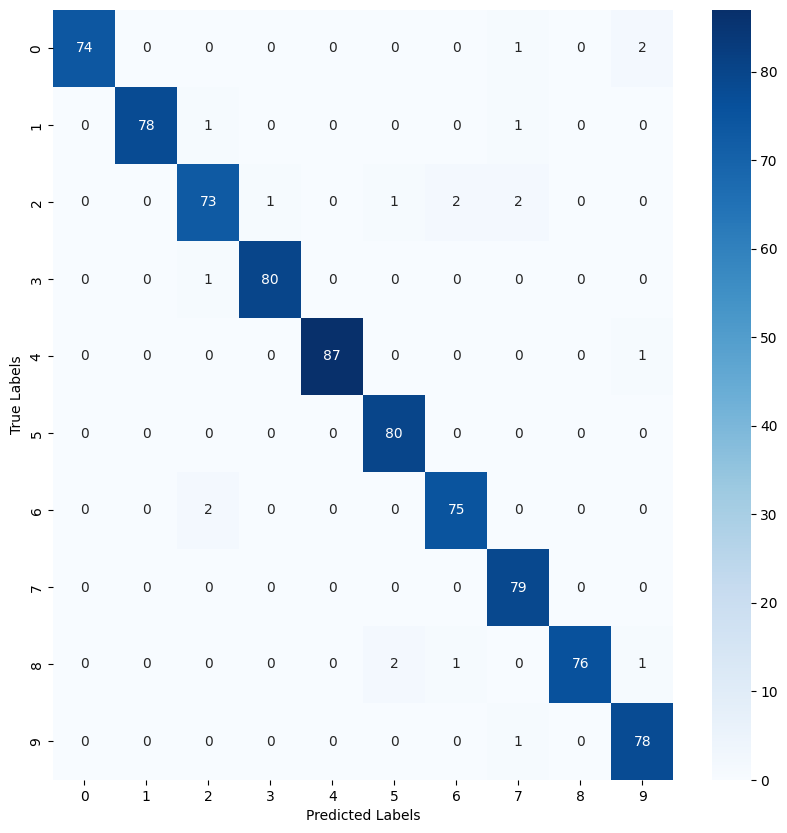

In [ ]:
# LOAD TRAINED MODEL
learn.load('stage-1')

# GET PREDICTIONS AND TRUTH VALUES
preds, targs = learn.get_preds(dl=test_dls[0])  # Assuming that test_dls is a DataLoader containing test data
actual_preds = np.argmax(preds, axis=1)

# PRECISION, RECALL AND F1 SCORE
print("Precision: ", precision_score(targs, actual_preds, average='macro'))
print("Recall: ", recall_score(targs, actual_preds, average='macro'))
print("F1 Score: ", f1_score(targs, actual_preds, average='macro'))

# CONFUSION MATRIX
cm = confusion_matrix(targs, actual_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



<div class="alert alert-block alert-info">
<b>VGG16</b>
</div>

In [8]:
# VGG16 WITH BATCH NORMALISATION
learn = cnn_learner(dls, models.vgg16_bn, metrics=error_rate)
# FIT THE MODEL
learn.fit_one_cycle(4)
# SAVE MODEL
learn.save('stage-1')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:11<00:00, 48.5MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.790454,0.357230,0.117500,00:50
1,0.739675,0.167301,0.050000,00:42
2,0.365967,0.133294,0.045000,00:42
3,0.215729,0.124569,0.040000,00:41


Path('/content/drive/MyDrive/Assignment/Images/Train/models/stage-1.pth')

<div class="alert alert-block alert-info">
<b>VGG-16 Regularisation via Data Augmentation</b>
</div>

epoch,train_loss,valid_loss,error_rate,time
0,2.170309,0.536024,0.186250,00:50
1,1.072990,0.291132,0.100000,00:47
2,0.642862,0.266130,0.097500,00:48
3,0.489251,0.239205,0.085000,00:54


epoch,train_loss,valid_loss,error_rate,time
0,0.372969,0.215676,0.075000,01:06
1,0.318499,0.179310,0.066250,01:08
2,0.257807,0.153070,0.045000,01:06
3,0.223896,0.150500,0.051250,01:08


Path('/content/drive/MyDrive/Assignment/Images/Train/models/stage-1.pth')

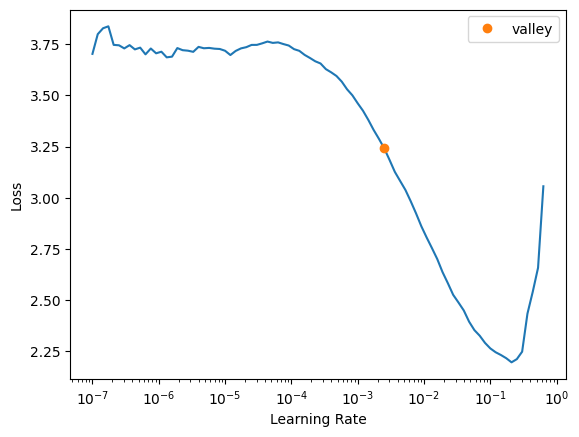

In [9]:
# DATA AUGMENTATION
dls = ImageDataLoaders.from_name_re(
    train_fold,
    fnames,
    pat=r'digit_(\d+)_row\d+_id_\d+.jpg$',
    item_tfms=Resize(460), # resize each image to be 460x460
    bs=64,
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]  # Randomly crop and resize to get a 224x224 region for each image, and normalize the RGB channels
)
# TRAIN VGG16
learn = cnn_learner(dls, models.vgg16_bn, metrics=error_rate)

# FIND LEARNING RATE
learn.lr_find()

# FIT THE MODEL
learn.fit_one_cycle(4, 1e-3)

# UNFREEZE THE MODEL
learn.unfreeze()

# FIT THE ENTIRE MODEL
learn.fit_one_cycle(4, slice(1e-5,1e-4))

# SAVE THE MODEL
learn.save('stage-1')

<div class="alert alert-block alert-info">
<b>VGG-16 Class Wise accuracy and confusion matrix</b>
</div>

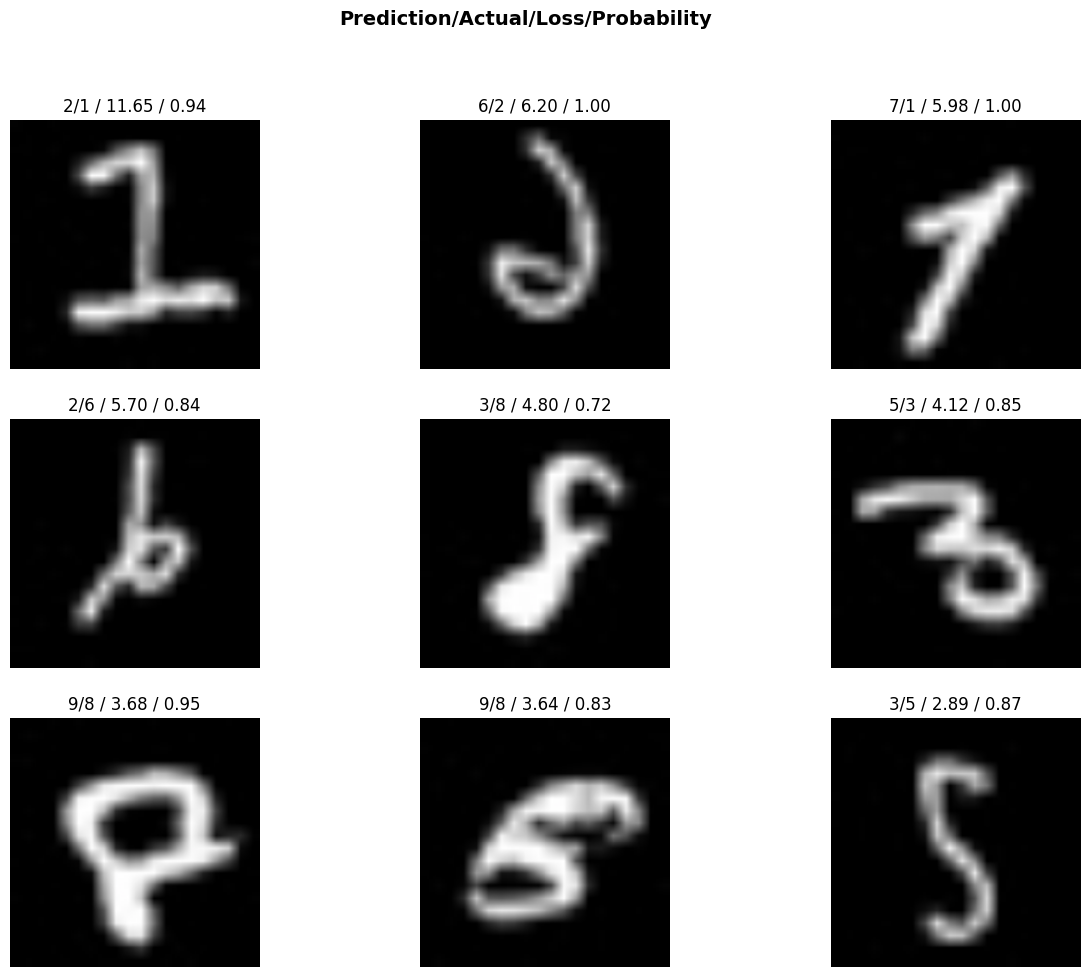

In [10]:
# PREDICTION/ACTUAL/LOSS/PROBABILITY
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

In [11]:
# CONFUSION MATRIX
interp = ClassificationInterpretation.from_learner(learn)
cm = interp.confusion_matrix()
class_accuracy = cm.diagonal()/cm.sum(axis=1)

# CLASS-WISE ACCURACY
class_labels = dls.vocab  # Get class labels
df = pd.DataFrame({'Class': class_labels, 'Accuracy': class_accuracy})
print(df)

# GET PREDICTIONS
preds, targs = learn.get_preds()
preds = preds.argmax(dim=1)

# PRECISION, RECALL AND F1 SCORE
print("Precision: ", precision_score(targs, preds, average='macro'))
print("Recall: ", recall_score(targs, preds, average='macro'))
print("F1 Score: ", f1_score(targs, preds, average='macro'))



  Class  Accuracy
0     0  0.961538
1     1  0.950617
2     2  0.857143
3     3  0.915663
4     4  0.988506
5     5  0.913043
6     6  0.965517
7     7  0.973684
8     8  0.961039
9     9  1.000000


Precision:  0.9532405002146194
Recall:  0.9486750891566238
F1 Score:  0.9502325715058474


<div class="alert alert-block alert-info">
<b>VGG16 Testing Data</b>
</div>

  Class  Accuracy
0     0  0.961039
1     1  0.975000
2     2  0.860759
3     3  0.901235
4     4  0.954545
5     5  0.862500
6     6  0.974026
7     7  1.000000
8     8  0.937500
9     9  0.987342
Precision:  0.9421509878970893
Recall:  0.9413946223334408
F1 Score:  0.9410902474305363


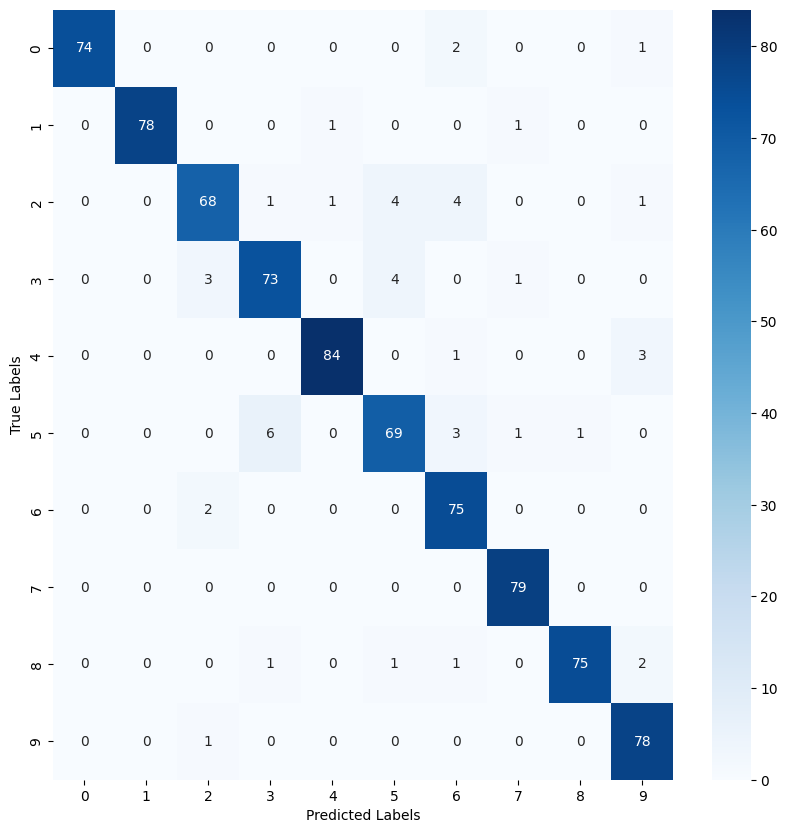

In [12]:
# LOAD MODEL
learn.load('stage-1')

# GET PREDICTIONS AND TRUTH VALUES
preds, targs = learn.get_preds(dl=test_dls[0])  # Assuming that test_dls is a DataLoader containing test data
actual_preds = np.argmax(preds, axis=1)

# CONFUSION MATRIX
cm = confusion_matrix(targs, actual_preds)
class_accuracy = cm.diagonal()/cm.sum(axis=1)

# CLASSS-WISE ACCURACY
class_labels = dls.vocab  # Get class labels
df = pd.DataFrame({'Class': class_labels, 'Accuracy': class_accuracy})
print(df)

# PRECISION, RECALL AND F1 SCORE
print("Precision: ", precision_score(targs, actual_preds, average='macro'))
print("Recall: ", recall_score(targs, actual_preds, average='macro'))
print("F1 Score: ", f1_score(targs, actual_preds, average='macro'))


# PLOT THE CONFUSION MATRIX
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<div class="alert alert-block alert-info">
<b>RESNET</b>
</div>

In [13]:
# RETRIEVE RESNET MODEL
learn = cnn_learner(dls, resnet34, metrics=error_rate)
# FIT THE MODEL
learn.fit_one_cycle(4)
# SAVE THE MODEL
learn.save('stage-1')

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593

epoch,train_loss,valid_loss,error_rate,time
0,2.145350,0.903836,0.327500,00:43
1,1.011290,0.304331,0.097500,00:40
2,0.613050,0.218945,0.067500,00:40
3,0.454349,0.208515,0.063750,00:40


Path('/content/drive/MyDrive/Assignment/Images/Train/models/stage-1.pth')

In [14]:
# UNFREEZING THE REST OF THE NETWORK
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.491019,0.233121,0.076250,00:44


SuggestedLRs(valley=2.511886486900039e-05)

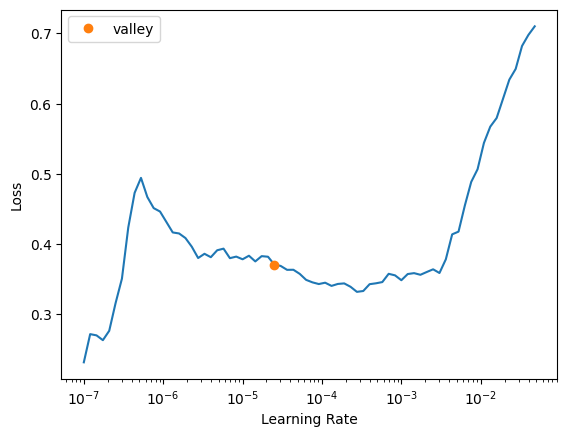

In [15]:
# LOAD THE MODEL
learn.load('stage-1')
# FIND THE LEARNING RATE
learn.lr_find()

<div class="alert alert-block alert-info">
<b>ResNet Fine-tuning</b>
</div>

In [16]:
# UNFREEZING THE REST OF THE NETWORK
learn.unfreeze()
# SCHEDULE THE LEARNING RATE WHERE SLOPE IS NOT INCREASING
learn.fit_one_cycle(25, lr_max=slice(1e-5,1e-4))
# THIS USUALLY YIELDS GOOD PERFORMANCE
learn.save('stage-1')

epoch,train_loss,valid_loss,error_rate,time
0,0.319987,0.206201,0.062500,00:38
1,0.310442,0.178577,0.052500,00:37
2,0.283862,0.156034,0.056250,00:37
3,0.244517,0.129725,0.045000,00:41
4,0.208612,0.136437,0.045000,00:31
5,0.174617,0.106847,0.030000,00:31
6,0.146325,0.098638,0.031250,00:41
7,0.121013,0.110147,0.037500,00:43
8,0.098522,0.085982,0.025000,00:42
9,0.082604,0.087952,0.022500,00:36


Path('/content/drive/MyDrive/Assignment/Images/Train/models/stage-1.pth')

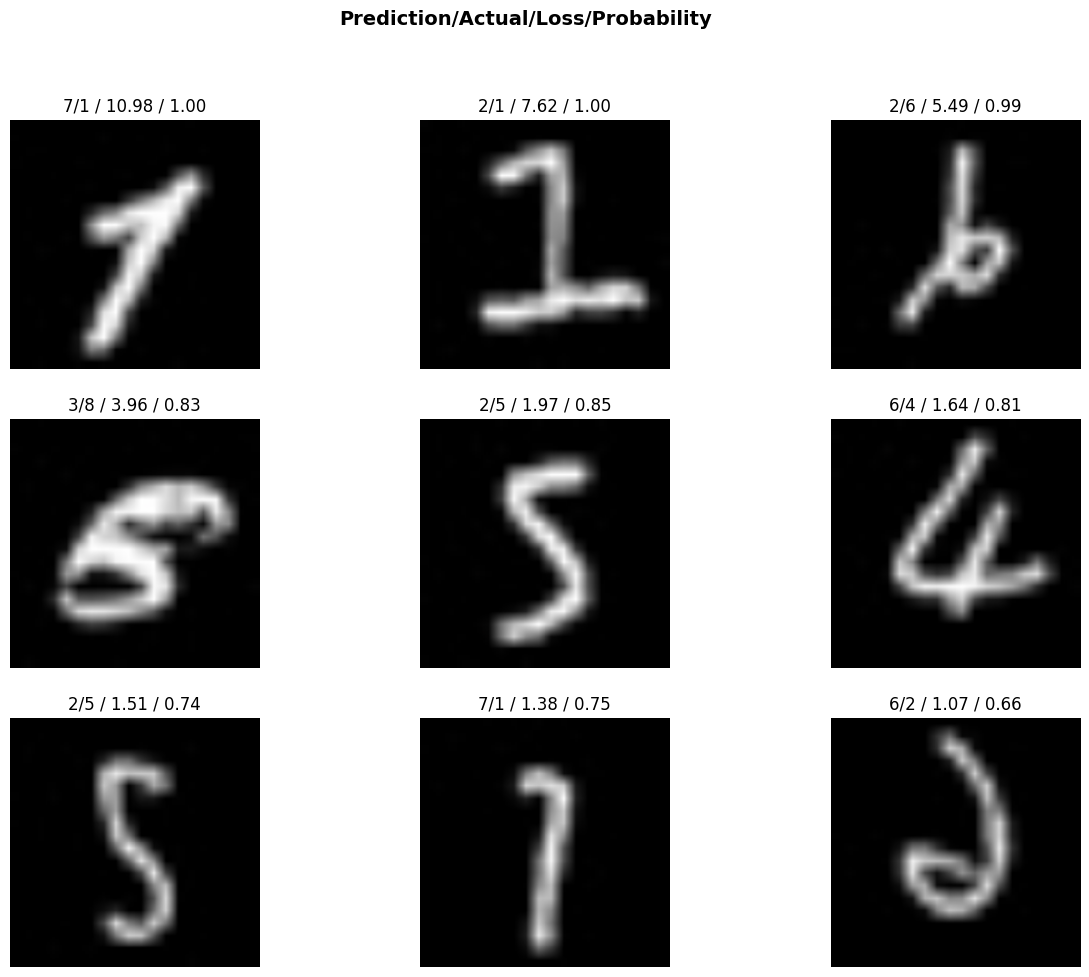

In [17]:
# PREDICTION/ACTUAL/LOSS/PROBABILITY
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

In [18]:
# CONFUSION MATRIX
cm = interp.confusion_matrix()
class_accuracy = cm.diagonal()/cm.sum(axis=1)

# CLASS-WISE ACCURACY
class_labels = dls.vocab  # Get class labels
df = pd.DataFrame({'Class': class_labels, 'Accuracy': class_accuracy})
print(df)

# GET PREDICTIONS
preds, targs = learn.get_preds()
preds = preds.argmax(dim=1)

# PRECISION, RECALL AND F1 SCORE
print("Precision: ", precision_score(targs, preds, average='macro'))
print("Recall: ", recall_score(targs, preds, average='macro'))
print("F1 Score: ", f1_score(targs, preds, average='macro'))



  Class  Accuracy
0     0  1.000000
1     1  0.962963
2     2  0.985714
3     3  1.000000
4     4  0.988506
5     5  0.978261
6     6  0.988506
7     7  1.000000
8     8  0.987013
9     9  0.985507


Precision:  0.9872159372159371
Recall:  0.987646984588514
F1 Score:  0.9872742939127834


<div class="alert alert-block alert-info">
<b>Testing the "Test" data</b>
</div>

  Class  Accuracy
0     0  1.000000
1     1  0.962500
2     2  0.936709
3     3  0.975309
4     4  0.988636
5     5  0.975000
6     6  0.987013
7     7  1.000000
8     8  0.987500
9     9  1.000000
Precision:  0.9811914218723162
Recall:  0.9812666853384153
F1 Score:  0.9811525357183853


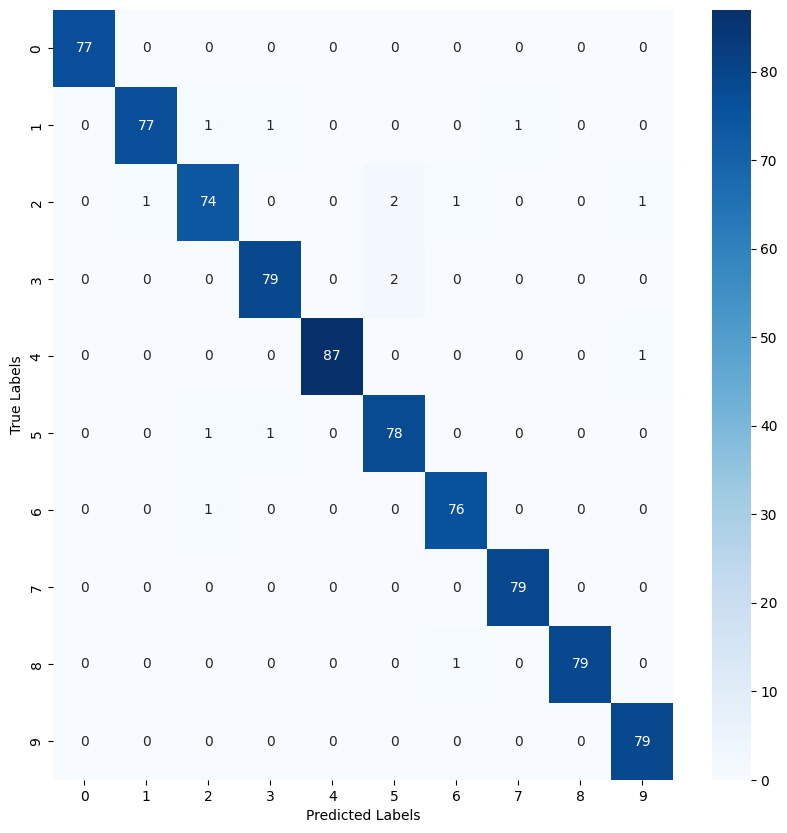

In [19]:
# LOAD TRAINED MODEL
learn.load('stage-1')

# GET PREDICTIONS AND TRUTH VALUES
preds, targs = learn.get_preds(dl=test_dls[0])  # Assuming that test_dls is a DataLoader containing test data
actual_preds = np.argmax(preds, axis=1)

# CONFUSION MATRIX
cm = confusion_matrix(targs, actual_preds)
class_accuracy = cm.diagonal()/cm.sum(axis=1)

# CLASS-WISE ACCURACY
class_labels = dls.vocab  # Get class labels
df = pd.DataFrame({'Class': class_labels, 'Accuracy': class_accuracy})
print(df)

# PRECISION, RECALL AND F1 SCORE
print("Precision: ", precision_score(targs, actual_preds, average='macro'))
print("Recall: ", recall_score(targs, actual_preds, average='macro'))
print("F1 Score: ", f1_score(targs, actual_preds, average='macro'))


# PLOT THE CONFUSION MATRIX
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()